Color card detection and color correction using PlantCV

In [1]:
# Import libraries

from plantcv import plantcv as pcv
import cv2
from matplotlib.pylab import plt
import pandas as pd
from urllib.request import urlopen, urlretrieve
from imageio import imread, imsave
from matplotlib.pylab import plt
import numpy as np
import colorsys
import matplotlib.colors as colors
from plantcv import plantcv as pcv

class options:
    def __init__(self):
        self.debug = "plot"
        self.writeimg= False
        self.result = "color_tutorial_results.json"
        self.outdir = "."
        
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug

In [2]:
# images to identify the color card

img0001 = imread('IMG_0001.JPG')
img0002 = imread('IMG_0002.JPG')


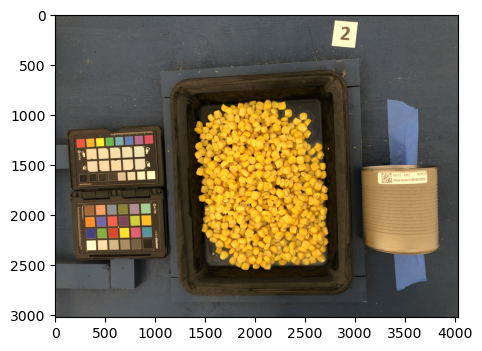

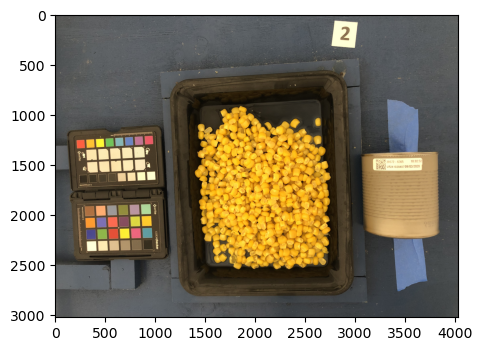

In [3]:
target_img, targetpath, targetname = pcv.readimage(filename="IMG_0001.JPG")
target_img2, targetpath, targetname = pcv.readimage(filename="IMG_0002.JPG")

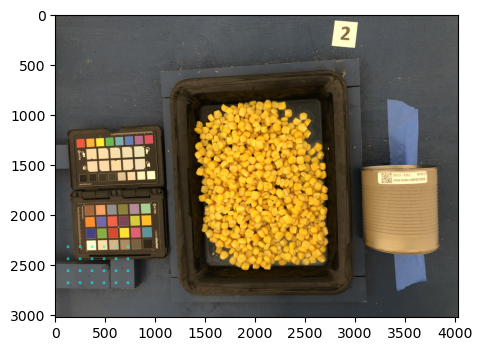

In [4]:
#First, we try to detect the color card in the pictures, but as the images have 
# two color cards the pipeline is not able to detect the color card with 24 colors 

target_mask = pcv.transform.create_color_card_mask(rgb_img=target_img, radius=10, start_coord=(130,2320), spacing=(120,120), ncols=6, nrows=4)



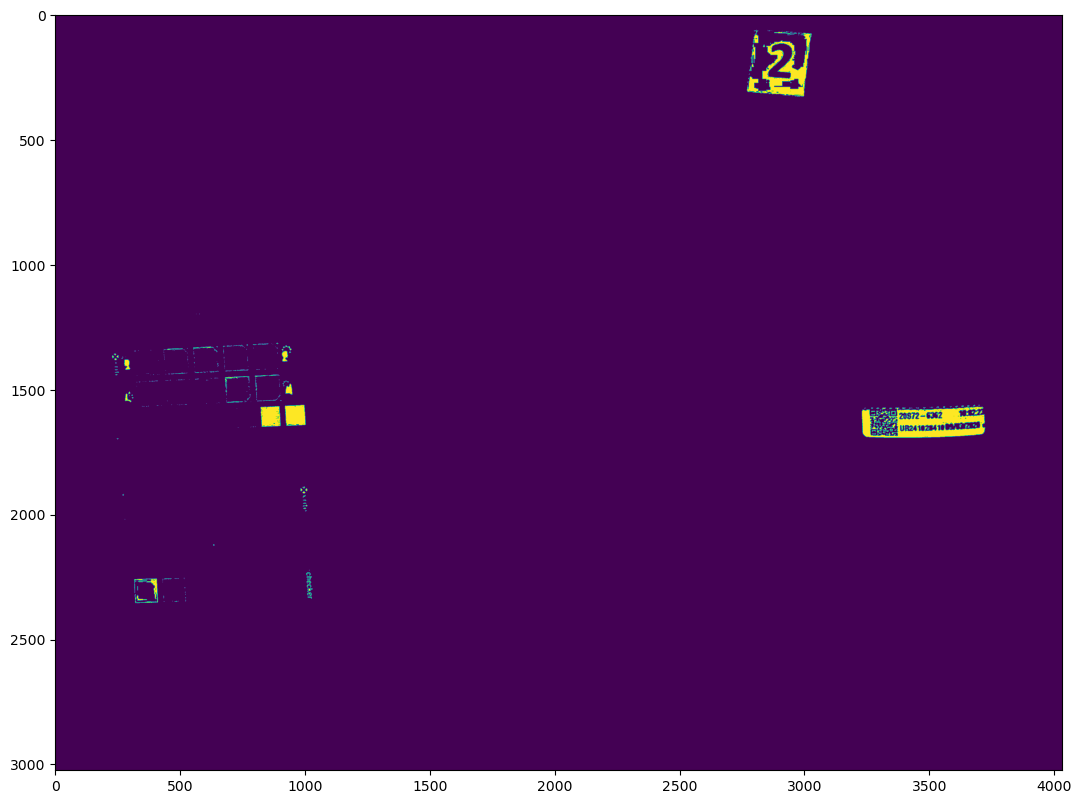

In [5]:
# To isolate the color card we use different HSV combinations 

hsv = colors.rgb_to_hsv(img0001)

hmin= 0.1
hmax= 0.2
smin= 0.2
smax= 0.3
vmin= 250
vmax= 300

h1 = hsv[:,:,0] > hmin 
h2 = hsv[:,:,0] < hmax 
s1 = hsv[:,:,1] > smin
s2 = hsv[:,:,1] < smax
v1 = hsv[:,:,2] > vmin
v2 = hsv[:,:,2] < vmax

binary_image = h1 & h2 & s1 & s2 & v1 & v2 


plt.figure(figsize=(20,10));
plt.imshow(binary_image)

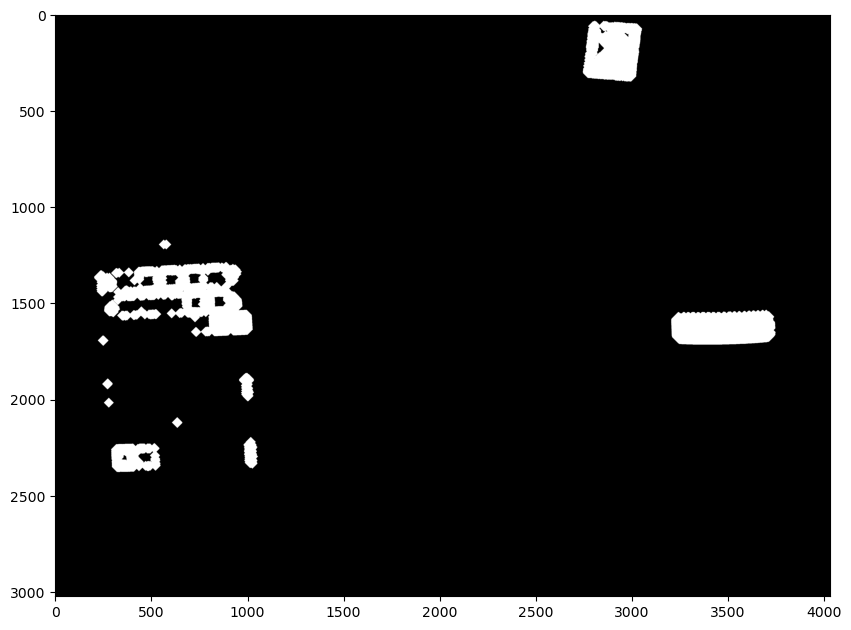

In [6]:
# Then, we made a binary dilation to construct a matrix of ones and zeros.

from scipy import ndimage


after_dialation = ndimage.binary_dilation(binary_image, iterations=25)
plt.figure(figsize = (10,20));
plt.imshow(after_dialation, cmap='gray', vmin=0, vmax=1);
plt.show()

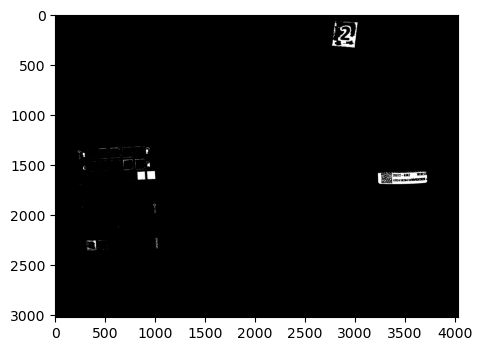

In [7]:
# Here we use the binary dilation to masked the binary image that we got with HSV filters 

masked = pcv.apply_mask(img = binary_image, mask = after_dialation, mask_color='black').astype(np.uint8)

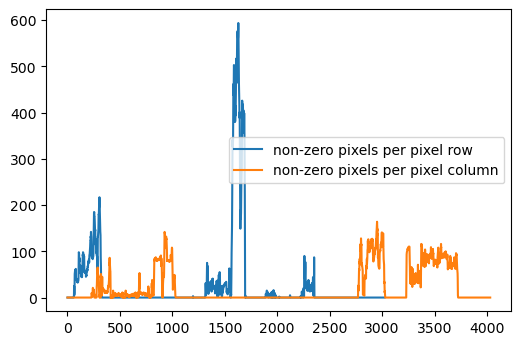

In [8]:
# To identify the columns and rows where the color cards is located 
# we add the columns an rows values
plt.plot(np.sum(binary_image,axis=1), label = 'non-zero pixels per pixel row')
plt.plot(np.sum(binary_image,axis=0), label = 'non-zero pixels per pixel column')
plt.legend()

In [9]:
#Then, we filter the columns and rows to get the coordinates of the color panel
axis_0=np.where(np.sum(after_dialation, axis=0) > 400)
axis_1=np.where(np.sum(after_dialation, axis=1) > 400)

In [10]:
st1=0
st2=axis_1[0][-1]
en1=axis_0[0][-1]
en2=3000

st2,en2,st1,en1

(1711, 3000, 0, 1004)

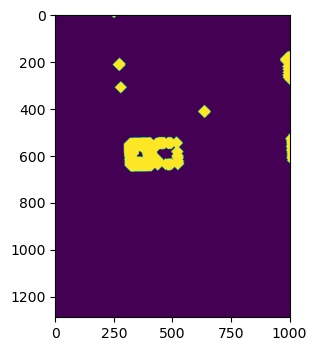

In [11]:
plt.imshow(after_dialation[st2:en2,st1:en1])

In [13]:
img0001_panel = img0001[st2:en2,st1:en1]

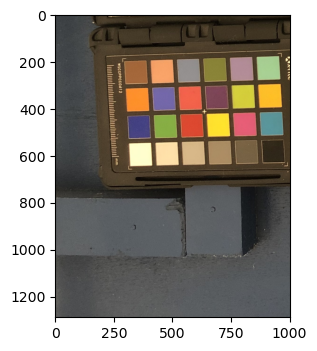

In [14]:
plt.imshow(img0001_panel)

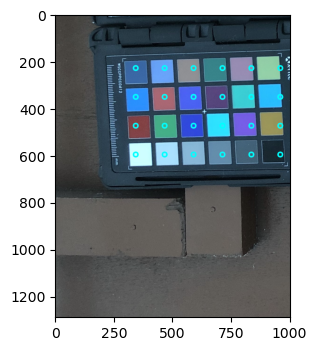

In [17]:
# Now, we can detect the color panel!!!
from plantcv import plantcv as pcv
rgb_img = img0001_panel
df, start, space = pcv.transform.find_color_card(rgb_img=img0001_panel)


target_mask = pcv.transform.create_color_card_mask(rgb_img=rgb_img, radius=10, start_coord=start, spacing=space, ncols=6, nrows=4)


Unfortunately, we were not able to use the isolated color panel to correct the pictures so we used another approach

2. In this part we used color panel's coordinates 

This function outputs target_matrix, source_matrix, and transformation_matrix and saves them to the output directory as .npz files.

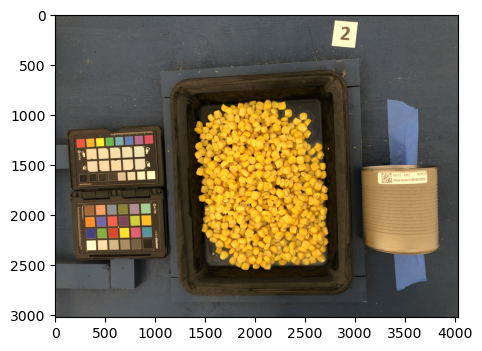

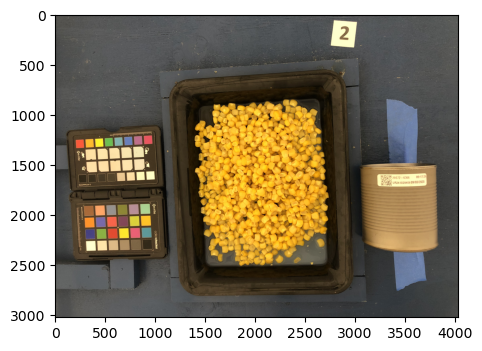

In [3]:
# parameters
#target_img - an RGB image with color chips visualized
#source_img - an RGB image with color chips visualized

target_img, t_path, t_filename = pcv.readimage(filename="IMG_0001.JPG")
source_img, s_path, s_filename = pcv.readimage(filename="IMG_0003.JPG")


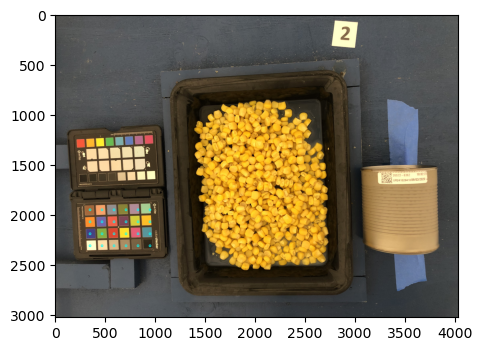

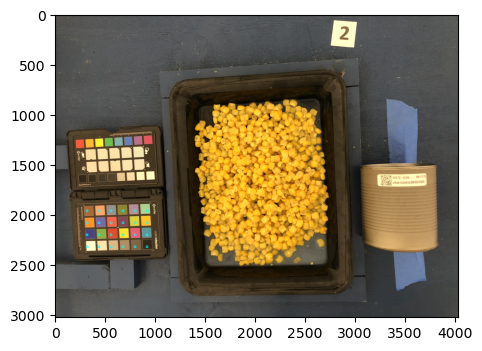

In [4]:
# target_mask - a grayscale image with color chips and background each represented with unique values
# source_mask - a grayscale image with color chips and background each represented as unique values

target_mask = pcv.transform.create_color_card_mask(rgb_img=target_img, radius=10, start_coord=(350,1950), spacing=(120,120), ncols=6, nrows=4)
source_mask = pcv.transform.create_color_card_mask(rgb_img=source_img, radius=10, start_coord=(320,1960), spacing=(120,120), ncols=6, nrows=4)



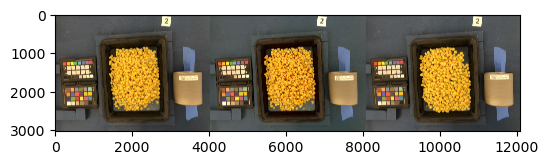

In [5]:
# output_directory - a file path to which the target_matrix, source_matrix, 
# and transformation_matrix will be save as .npz files

outdir = "."

# Set global debug behavior to None (default), "print" (to file), or "plot" (Jupyter Notebooks or X11)
pcv.params.debug = 'plot'

target_matrix, source_matrix, transformation_matrix, corrected_img = pcv.transform.correct_color(target_img=target_img, 
                                                                                                 target_mask=target_mask, 
                                                                                                 source_img=source_img,  
                                                                                                 source_mask=source_mask, 
                                                                                                 output_directory=outdir) 
  